In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext autotime

from ngram import *
from baselines import *
from error_analysis import *
from deep_learning import *
pd.options.mode.chained_assignment = None

Using TensorFlow backend.


### Load Annotated Data

In [2]:
task = 'aggression'
xtype = 'ngams'
ytype = 'empirical_dist'
n_classes = 3

time: 2.51 ms


In [3]:
data = load_comments_and_labels(task)

time: 1min 51s


### NGram Preprocessing

In [4]:
feature_pipeline =  Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,5), analyzer = 'char', max_features = 10000)),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('to_dense', DenseTransformer()), 
])

X_comments, _ = assemble_data(data, 'comments', ytype, splits = ['train'])
preprocessor = feature_pipeline.fit(X_comments)
data = apply_transform(data, 'comments', preprocessor, xtype)

X_train, y_train = assemble_data(data, xtype, ytype, splits = ['train'])
X_test, y_test = assemble_data(data, xtype, 'empirical_dist', splits = ['test'])

time: 4min 53s


### Define Model

In [5]:
clf =  KerasClassifier(build_fn=make_MLP, output_dim = n_classes, input_dim = 10000)

time: 18.8 ms


### Deep EDP Hyper-Parameter tuning

In [6]:
# Deep EDP

param_grid = {
    'l': (0, 0.00001, 0.0001, 0.001),
    'nb_epoch' : (1,),
    'batch_size': (100,),
    'layers': ([50, 10],),
}

tune (X_train, y_train, clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/1
20847/20847 [==============================] - 5s     
Epoch 1/1
20847/20847 [==============================] - 5s     
Epoch 1/1
20847/20847 [==============================] - 5s     
Epoch 1/1
20847/20847 [==============================] - 5s     

Best parameters set found:
{'l': 0.0001, 'nb_epoch': 1, 'layers': [50, 10], 'batch_size': 100} 0.925473535697


Grid scores:
0.92404 (+/-0.00000) for {'l': 0, 'nb_epoch': 1, 'layers': [50, 10], 'batch_size': 100}
0.92481 (+/-0.00000) for {'l': 1e-05, 'nb_epoch': 1, 'layers': [50, 10], 'batch_size': 100}
0.92547 (+/-0.00000) for {'l': 0.0001, 'nb_epoch': 1, 'layers': [50, 10], 'batch_size': 100}
0.83502 (+/-0.00000) for {'l': 0.001, 'nb_epoch': 1, 'layers': [50, 10], 'batch_size': 100}
time: 3min 2s


Seems, like we don't need to regularize at one epoch. Lets try more epochs.

In [7]:
# Deep EDP
param_grid = {
    'l': (0, 0.00001, 0.0001, 0.001),
    'nb_epoch' : (2,),
    'batch_size': (100,),
    'layers': ([50, 10],),
}

tune (X_train, y_train, clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/2
48643/48643 [==============================] - 28s - loss: 0.2468 - acc: 0.8689    
Epoch 2/2
20847/20847 [==============================] - 5s     
Epoch 1/2
48643/48643 [==============================] - 26s - loss: 0.2618 - acc: 0.8654    
Epoch 2/2
20847/20847 [==============================] - 5s     
Epoch 1/2
48643/48643 [==============================] - 26s - loss: 0.2953 - acc: 0.8533    
Epoch 2/2
20847/20847 [==============================] - 6s     
Epoch 1/2
48643/48643 [==============================] - 26s - loss: 0.4305 - acc: 0.8275    
Epoch 2/2
20847/20847 [==============================] - 6s     

Best parameters set found:
{'l': 0, 'nb_epoch': 2, 'layers': [50, 10], 'batch_size': 100} 0.93649300955


Grid scores:
0.93649 (+/-0.00000) for {'l': 0, 'nb_epoch': 2, 'layers': [50, 10], 'batch_size': 100}
0.93530 (+/-0.00000) for {'l': 1e-05, 'nb_epoch': 2, 'layers': [50, 10], 'batch_size': 100}
0.92558 (+/-0.00000) for {'l': 0.0001, 'nb_epoch': 2, 'layers': 

Same pattern. Results improved for lower reg. Lets try more epochs.

In [8]:
# Deep EDP
param_grid = {
    'l': (0, 0.00001, 0.0001, 0.001),
    'nb_epoch' : (4,),
    'batch_size': (100,),
    'layers': ([50, 10],),
}

tune (X_train, y_train, clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/4
48643/48643 [==============================] - 26s - loss: 0.2537 - acc: 0.8642    
Epoch 2/4
48643/48643 [==============================] - 21s - loss: 0.1464 - acc: 0.9038    
Epoch 3/4
48643/48643 [==============================] - 21s - loss: 0.1359 - acc: 0.9097    
Epoch 4/4
20847/20847 [==============================] - 6s     
Epoch 1/4
48643/48643 [==============================] - 26s - loss: 0.2507 - acc: 0.8668    
Epoch 2/4
48643/48643 [==============================] - 21s - loss: 0.1546 - acc: 0.9021    
Epoch 3/4
48643/48643 [==============================] - 21s - loss: 0.1460 - acc: 0.9081    
Epoch 4/4
20847/20847 [==============================] - 6s     
Epoch 1/4
48643/48643 [==============================] - 26s - loss: 0.2823 - acc: 0.8681    
Epoch 2/4
48643/48643 [==============================] - 20s - loss: 0.1789 - acc: 0.8993    
Epoch 3/4
48643/48643 [==============================] - 21s - loss: 0.1688 - acc: 0.9027    
Epoch 4/4
20847/20847 [=

Same pattern still, although performance has plateaued.

Right now, 4 epochs and no regularization is best. Lets add more layers.

In [9]:
# Deep EDP
param_grid = {
    'l': (0.000001,),
    'nb_epoch' : (2,),
    'batch_size': (100,),
    'layers': ([50, 50, 10],),
}

tune (X_train, y_train, clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/2
48643/48643 [==============================] - 27s - loss: 0.2725 - acc: 0.8624    
Epoch 2/2
20847/20847 [==============================] - 6s     

Best parameters set found:
{'l': 1e-06, 'nb_epoch': 2, 'layers': [50, 50, 10], 'batch_size': 100} 0.935280894983


Grid scores:
0.93528 (+/-0.00000) for {'l': 1e-06, 'nb_epoch': 2, 'layers': [50, 50, 10], 'batch_size': 100}
time: 1min 16s


Adding more layers did not help.

### Linear EDP Tuning

In [10]:
# Linear EDP
param_grid = {
    'l': (0,),
    'nb_epoch' : (1,2,4,8,16),
    'batch_size': (100,),
    'layers': ([],),
}

tune (X_train, y_train, clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/1
20847/20847 [==============================] - 5s     
Epoch 1/2
48643/48643 [==============================] - 14s - loss: 0.2857 - acc: 0.8512    
Epoch 2/2
20847/20847 [==============================] - 5s     
Epoch 1/4
48643/48643 [==============================] - 14s - loss: 0.2873 - acc: 0.8498    
Epoch 2/4
48643/48643 [==============================] - 9s - loss: 0.1975 - acc: 0.8802     
Epoch 3/4
48643/48643 [==============================] - 8s - loss: 0.1739 - acc: 0.8877     
Epoch 4/4
20847/20847 [==============================] - 4s     
Epoch 1/8
48643/48643 [==============================] - 14s - loss: 0.2868 - acc: 0.8487    
Epoch 2/8
48643/48643 [==============================] - 9s - loss: 0.1970 - acc: 0.8786     
Epoch 3/8
48643/48643 [==============================] - 8s - loss: 0.1737 - acc: 0.8875     
Epoch 4/8
48643/48643 [==============================] - 8s - loss: 0.1630 - acc: 0.8916     
Epoch 5/8
48643/48643 [==============================

We won't bother regularizing. Lets just tune epochs. Seems to max out at 8.

### Linear OH Tuning

In [11]:
# Linear OH
param_grid = {
    'l': (0,),
    'nb_epoch' : (1,2,4,8,16),
    'batch_size': (100,),
    'layers': ([],),
}

tune (X_train, one_hot(y_train), clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/1
20847/20847 [==============================] - 6s     
Epoch 1/2
48643/48643 [==============================] - 16s - loss: 0.4835 - acc: 0.8457    
Epoch 2/2
20847/20847 [==============================] - 5s     
Epoch 1/4
48643/48643 [==============================] - 15s - loss: 0.4822 - acc: 0.8489    
Epoch 2/4
48643/48643 [==============================] - 10s - loss: 0.3578 - acc: 0.8776    
Epoch 3/4
48643/48643 [==============================] - 10s - loss: 0.3190 - acc: 0.8872    
Epoch 4/4
20847/20847 [==============================] - 5s     
Epoch 1/8
48643/48643 [==============================] - 16s - loss: 0.4867 - acc: 0.8440    
Epoch 2/8
48643/48643 [==============================] - 12s - loss: 0.3612 - acc: 0.8762    
Epoch 3/8
48643/48643 [==============================] - 11s - loss: 0.3221 - acc: 0.8858    
Epoch 4/8
48643/48643 [==============================] - 11s - loss: 0.2996 - acc: 0.8914    
Epoch 5/8
48643/48643 [==============================

Lets try more epochs.

In [12]:
param_grid = {
    'l': (0,),
    'nb_epoch' : (24, 32),
    'batch_size': (100,),
    'layers': ([],),
}

tune (X_train, one_hot(y_train), clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/24
48643/48643 [==============================] - 14s - loss: 0.4884 - acc: 0.8438    
Epoch 2/24
48643/48643 [==============================] - 9s - loss: 0.3622 - acc: 0.8756     
Epoch 3/24
48643/48643 [==============================] - 9s - loss: 0.3223 - acc: 0.8858     
Epoch 4/24
48643/48643 [==============================] - 10s - loss: 0.2996 - acc: 0.8919    
Epoch 5/24
48643/48643 [==============================] - 9s - loss: 0.2845 - acc: 0.8956     
Epoch 6/24
48643/48643 [==============================] - 10s - loss: 0.2731 - acc: 0.8989    
Epoch 7/24
48643/48643 [==============================] - 10s - loss: 0.2641 - acc: 0.9014    
Epoch 8/24
48643/48643 [==============================] - 9s - loss: 0.2568 - acc: 0.9034     
Epoch 9/24
48643/48643 [==============================] - 9s - loss: 0.2505 - acc: 0.9057     
Epoch 10/24
48643/48643 [==============================] - 9s - loss: 0.2452 - acc: 0.9067     
Epoch 11/24
48643/48643 [========================

### Eval SKlearn

In [13]:
sk_model = LogisticRegression(C = 5.0,  solver = 'sag')
sk_model.fit(X_train, y_train.argmax(axis = 1))
roc_df, spearman_df = test_cross(sk_model, data, xtype)

time: 6min 20s


In [14]:
roc_df

,random,blocked,both
user,0.917106,0.922955,0.930791
article,0.854593,0.922942,0.899541
both,0.912956,0.931098,0.934040


time: 167 ms


In [15]:
spearman_df

,random,blocked,both
user,0.594571,0.754852,0.758902
article,0.275159,0.504413,0.446138
both,0.454013,0.692251,0.659666


time: 6.03 ms


### Eval OH

In [16]:
oh_linear_model =  KerasClassifier(build_fn=make_MLP,
                               output_dim = n_classes,
                               input_dim = 10000,
                               nb_epoch = 24,
                               batch_size = 100,
                               l = 0.0, 
                               layers = [])
oh_linear_model.fit(X_train, one_hot(y_train))
roc_df, spearman_df = test_cross(oh_linear_model, data, xtype)

Epoch 1/24
69490/69490 [==============================] - 19s - loss: 0.4524 - acc: 0.8540    
Epoch 2/24
69490/69490 [==============================] - 13s - loss: 0.3351 - acc: 0.8822    
Epoch 3/24
69490/69490 [==============================] - 13s - loss: 0.3007 - acc: 0.8908    
Epoch 4/24
69490/69490 [==============================] - 13s - loss: 0.2816 - acc: 0.8957    
Epoch 5/24
69490/69490 [==============================] - 13s - loss: 0.2687 - acc: 0.8994    
Epoch 6/24
69490/69490 [==============================] - 12s - loss: 0.2592 - acc: 0.9016    
Epoch 7/24
69490/69490 [==============================] - 12s - loss: 0.2517 - acc: 0.9046    
Epoch 8/24
69490/69490 [==============================] - 12s - loss: 0.2457 - acc: 0.9065    
Epoch 9/24
69490/69490 [==============================] - 12s - loss: 0.2407 - acc: 0.9081    
Epoch 10/24
69490/69490 [==============================] - 13s - loss: 0.2365 - acc: 0.9097    
Epoch 11/24
69490/69490 [========================

In [17]:
roc_df

,random,blocked,both
user,0.908400,0.921779,0.928060
article,0.843194,0.918593,0.892355
both,0.904265,0.929550,0.930756


time: 36.2 ms


In [18]:
spearman_df

,random,blocked,both
user,0.589133,0.751809,0.757164
article,0.271392,0.500903,0.442840
both,0.449085,0.689645,0.657520


time: 8.72 ms


### Eval Linear EDP

In [19]:
ed_linear_model =  KerasClassifier(build_fn=make_MLP,
                               output_dim = n_classes,
                               input_dim = 10000,
                               nb_epoch = 8,
                               batch_size = 100,
                               l = 0.0, 
                               layers = [])
ed_linear_model.fit(X_train, y_train)
roc_df, spearman_df = test_cross(ed_linear_model, data, xtype)

Epoch 1/8
69490/69490 [==============================] - 19s - loss: 0.2637 - acc: 0.8576    
Epoch 2/8
69490/69490 [==============================] - 15s - loss: 0.1817 - acc: 0.8847    
Epoch 3/8
69490/69490 [==============================] - 15s - loss: 0.1643 - acc: 0.8925    
Epoch 4/8
69490/69490 [==============================] - 15s - loss: 0.1563 - acc: 0.8960    
Epoch 5/8
69490/69490 [==============================] - 15s - loss: 0.1514 - acc: 0.8989    
Epoch 6/8
69490/69490 [==============================] - 15s - loss: 0.1481 - acc: 0.9011    
Epoch 7/8
69490/69490 [==============================] - 15s - loss: 0.1456 - acc: 0.9023    
Epoch 8/8
23168/23168 [==============================] - 3s     
time: 2min 47s


In [20]:
roc_df

,random,blocked,both
user,0.911989,0.921245,0.927322
article,0.864289,0.921941,0.902902
both,0.912037,0.930118,0.932928


time: 15.6 ms


In [21]:
spearman_df

,random,blocked,both
user,0.663924,0.768345,0.787295
article,0.340899,0.552277,0.499326
both,0.537826,0.717361,0.699857


time: 14.1 ms


### Eval Deep EDP

In [22]:
deep_model =  KerasClassifier(build_fn=make_MLP,
                               output_dim = n_classes,
                               input_dim = 10000,
                               nb_epoch = 4,
                               batch_size = 100,
                               l = 0.0000001, 
                               layers = [50, 10])
deep_model.fit(X_train, y_train)
roc_df, spearman_df = test_cross(deep_model, data, xtype)

Epoch 1/4
69490/69490 [==============================] - 37s - loss: 0.2381 - acc: 0.8741    
Epoch 2/4
69490/69490 [==============================] - 32s - loss: 0.1438 - acc: 0.9052    
Epoch 3/4
69490/69490 [==============================] - 30s - loss: 0.1355 - acc: 0.9102    
Epoch 4/4
23168/23168 [==============================] - 4s     
time: 3min 4s


In [23]:
roc_df

,random,blocked,both
user,0.922832,0.926065,0.932012
article,0.871652,0.927582,0.909421
both,0.919759,0.933447,0.936626


time: 19.5 ms


In [24]:
spearman_df

,random,blocked,both
user,0.678412,0.784825,0.799240
article,0.355934,0.576075,0.518535
both,0.550585,0.734221,0.712985


time: 6.47 ms


### Check Calibration

23168/23168 [==============================] - 6s     


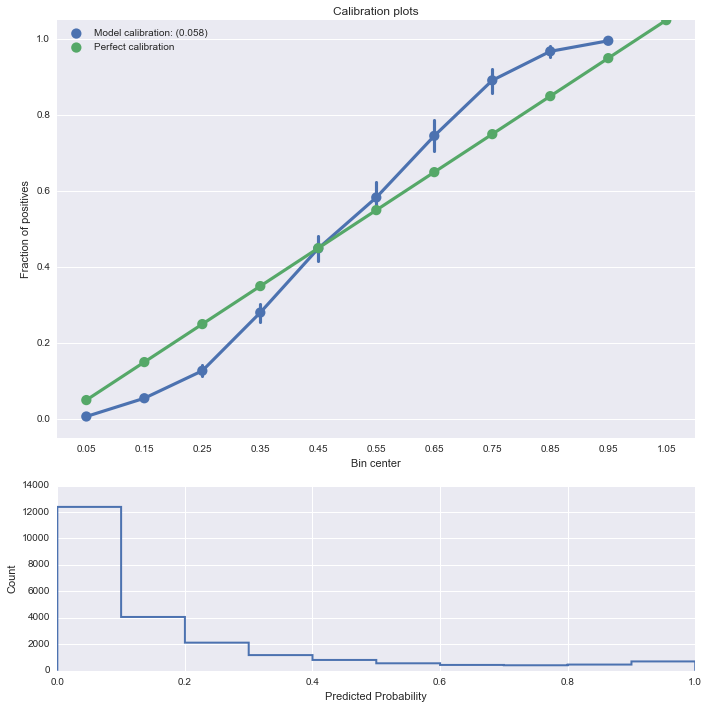

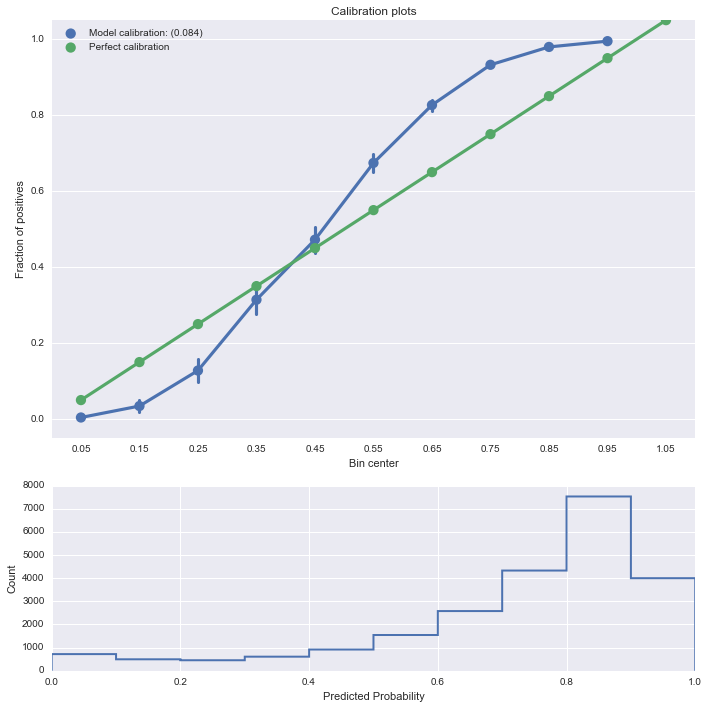

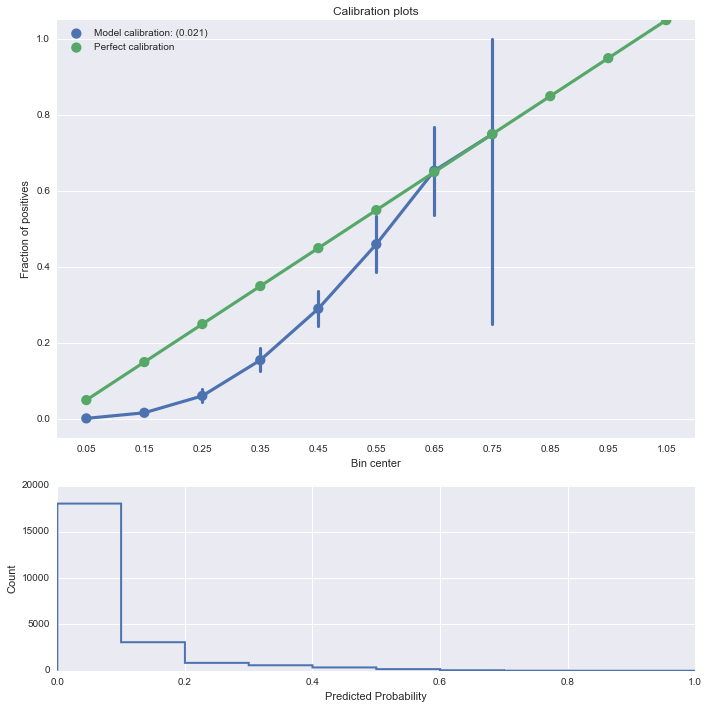

time: 10.6 s


In [25]:
y_test_oh = one_hot(y_test)
y_pred_ed = deep_model.predict_proba(X_test)

if n_classes > 2:
    classes = range(n_classes)
else:
    classes = [1]

for i in classes:
    plt.figure()
    calibration_curve_plotter(y_test_oh[:, i], y_pred_ed[:, i])
    plt.show()